# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path

import yaml
import pandas as pd
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [3]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"
# paths to combo dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = None
SBS_SAMPLE_PATTERN = None
SBS_PATH_METADATA = None
SBS_METADATA_ORDER_TYPE = None

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = "/lab/cheeseman_ops/brieflow-screens/logan-data/input_ph"
PHENOTYPE_SAMPLE_PATTERN = None
PHENOTYPE_PATH_METADATA = None
PHENOTYPE_METADATA_ORDER_TYPE = None

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [4]:
# get sample filepaths
data = []
for fp in Path(PHENOTYPE_IMAGES_DIR_FP).rglob("*.nd2"):
    filename = fp.stem  # Get filename without extension
    parts = filename.split("_")
    treatment = "mito" if "Enriched4Mito" in filename else "untreated"
    well = "A2" if treatment == "mito" else "A1"
    tile = int(parts[-1])  # Extract numeric part as tile

    data.append({"sample_fp": fp, "plate": 1, "well": well, "tile": tile, "treatment": treatment})

phenotype_samples = (
    pd.DataFrame(data).sort_values(["plate", "well", "tile"]).reset_index(drop=True)
)
phenotype_wildcard_combos = phenotype_samples[["plate", "well", "tile"]].astype(str)

# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)
phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
print("Phenotype wildcard combos:")
display(phenotype_wildcard_combos)

Phenotype samples:


,sample_fp,plate,well,tile,treatment
0,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A1,0,untreated
1,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A1,1,untreated
2,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A1,2,untreated
3,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A1,3,untreated
4,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A1,4,untreated
5,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A2,0,mito
6,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A2,1,mito
7,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A2,2,mito
8,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A2,3,mito
9,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,A2,4,mito


Phenotype wildcard combos:


,plate,well,tile
0,1,A1,0
1,1,A1,1
2,1,A1,2
3,1,A1,3
4,1,A1,4
5,1,A2,0
6,1,A2,1
7,1,A2,2
8,1,A2,3
9,1,A2,4


## Test Metadata Extraction

In [5]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_tile_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["plate"][0],
        phenotype_samples["well"][0],
        phenotype_samples["tile"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing tile 0 from file /lab/cheeseman_ops/brieflow-screens/logan-data/input_ph/Untreated_0000.nd2
File shape: (4, 2400, 2400)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'Z': 4, 'Y': 2400, 'X': 2400}
Phenotype test metadata:


,x_pos,y_pos,z_pos,pfs_offset,plate,well,tile,filename,channels,pixel_size_x,pixel_size_y
0,13779.5,-31254.2,3705.5,None,1,A1,0,/lab/cheeseman_ops/brieflow-screens/logan-data...,1,0.325,0.325


## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [6]:
SBS_CHANNEL_ORDER = None
PHENOTYPE_CHANNEL_ORDER = None
PHENOTYPE_ROUND_ORDER = None

In [7]:
SBS_CHANNEL_ORDER_FLIP = None
PHENOTYPE_CHANNEL_ORDER_FLIP = False

## Test ND2 Conversion

### Test phenotype conversion

Processing file 1/1: /lab/cheeseman_ops/brieflow-screens/logan-data/input_ph/Untreated_0000.nd2
Original dimensions for /lab/cheeseman_ops/brieflow-screens/logan-data/input_ph/Untreated_0000.nd2: ('Z', 'Y', 'X')
Array shape after processing: (1, 2400, 2400)
Final dimensions (CYX): (1, 2400, 2400)
Converted phenotype test sample:


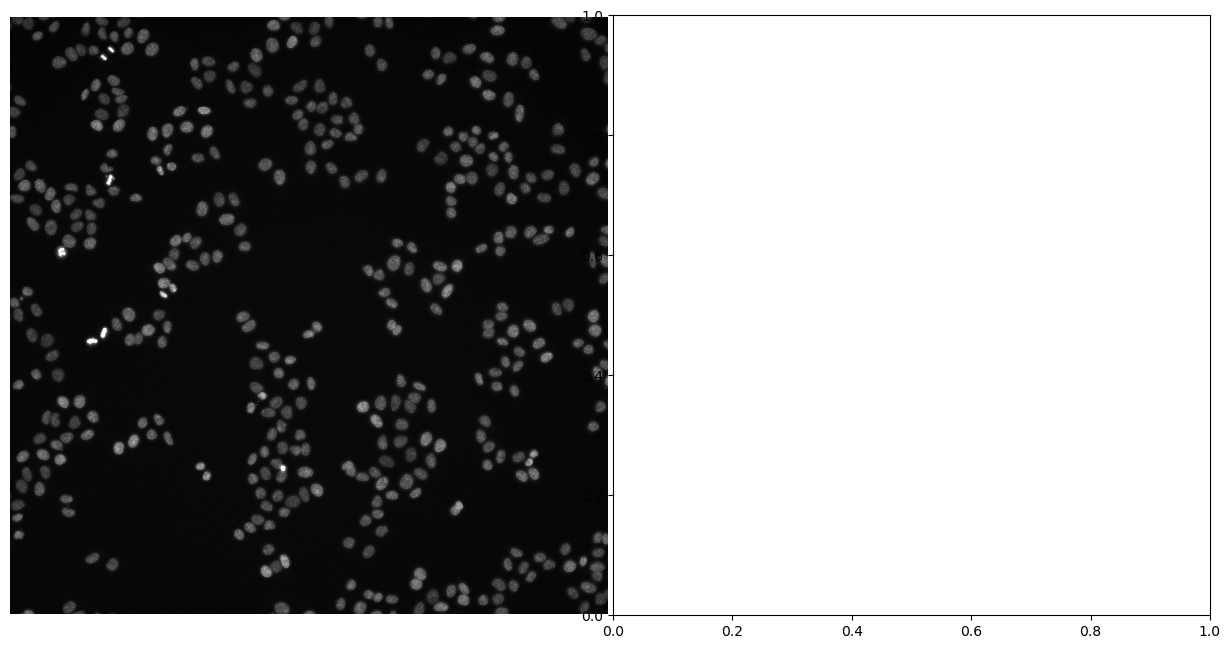

In [8]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=phenotype_samples["plate"][0],
        well=phenotype_samples["well"][0],
        tile=phenotype_samples["tile"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
    )
    # Convert test phenotype sample to tiff
    phenotype_image = nd2_to_tiff(
        phenotype_sample, PHENOTYPE_CHANNEL_ORDER_FLIP, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## Create config file with params

In [9]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)